### More In-Depth Visualization of Data

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic

script_path = os.getcwd()
root = os.path.abspath(os.path.join(script_path, os.pardir))
input_path = os.path.join(root, 'data', 'processed', 'monte_carlo_cartesian.csv')

In [10]:
# import cartesian dataframe
df = pd.read_csv(input_path)
pd.set_option('display.width', 180)

print(df)

    HVS            source_id          x     x_err          y      y_err          z      z_err            u       u_err           v       v_err           w       w_err
0     1   577294697514301440 -67.184379  8.501364 -64.232526   9.245545  53.349464   7.676057  -560.208919  217.078257 -449.656079  150.832620  129.374492  236.051739
1     4   699811079173836928 -53.436403  7.022294 -11.966555   1.854435  43.275064   6.703034  -430.870163   55.707446  -44.811340   62.965190  348.389756   58.854332
2     5  1069326945513133952 -36.718348  3.278295  19.170851   2.197751  27.719831   3.175424  -401.925991   15.634581  295.383488   29.981735  415.317856   16.006552
3     6  3867267443277880320 -20.667246  1.543387 -24.987662   3.074117  47.721298   5.868373  -112.916916   73.486367    5.554470   56.456263  555.287444   36.760144
4     7  3799146650623432704 -10.985665  0.343060 -27.551053   3.300521  44.281512   5.302280   -38.229259   42.157875  -37.119698   30.085068  449.992417   19.66931

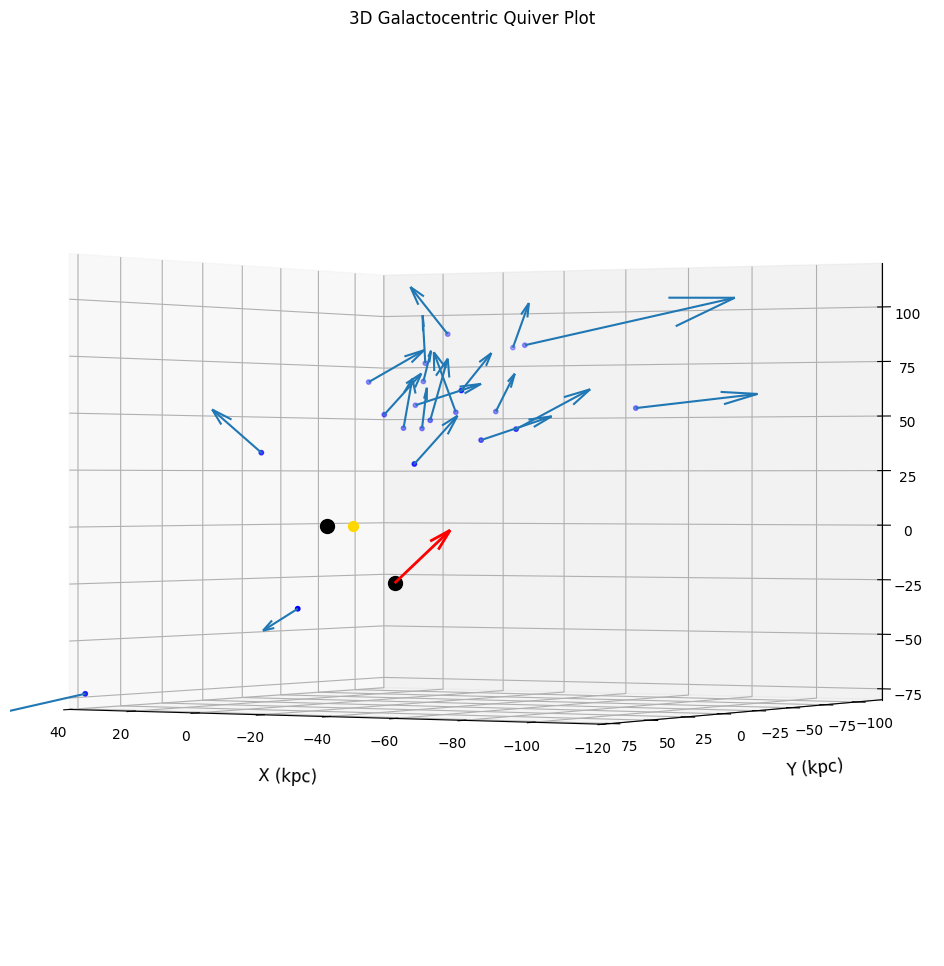

In [11]:
# 3d galactocentric quiver plot
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')

quiver = ax.quiver(
    df['x'], df['y'], df['z'],
    df['u'], df['v'], df['w'],
    length = 0.05,
    label="HVS and Velocity Vectors"
)
# HVS positions
ax.scatter(df['x'], df['y'], df['z'], color='blue', s=10, label='HVS Positions')
# Galactic Center
ax.scatter(0,0,0, color='black', s=100, label='Saggitarius A*')
# Sun
ax.scatter(-8.2, 0, 0.02, color='gold', s=50, label='Sun')
# LMC*
lmc_pos = [-1.5, -41.4, -26.7]
ax.scatter(lmc_pos[0], lmc_pos[1], lmc_pos[2], color='black', s=100, label='LMC*')
lmc_vel = [-57, -226, 221] # U, V, W in km/s
ax.quiver(
    lmc_pos[0], lmc_pos[1], lmc_pos[2], # Start the arrow at the LMC's position
    lmc_vel[0], lmc_vel[1], lmc_vel[2], # Vector components
    length=35.0, # Make the vector long enough to be easily visible
    normalize=True,
    color='red',
    linewidth=2,
    arrow_length_ratio=0.3,
    label='LMC Velocity Vector'
)

ax.set_xlabel('X (kpc)', fontsize=12, labelpad=20)
ax.set_ylabel('Y (kpc)', fontsize=12, labelpad=20)
ax.set_zlabel('Z (kpc)', fontsize=12, labelpad=20)
ax.set_xlim([-120, 40])
ax.set_ylim([-120, 80])
ax.set_zlim([-80, 120])

ax.set_title('3D Galactocentric Quiver Plot')
ax.view_init(elev=0., azim=120)
plt.show()

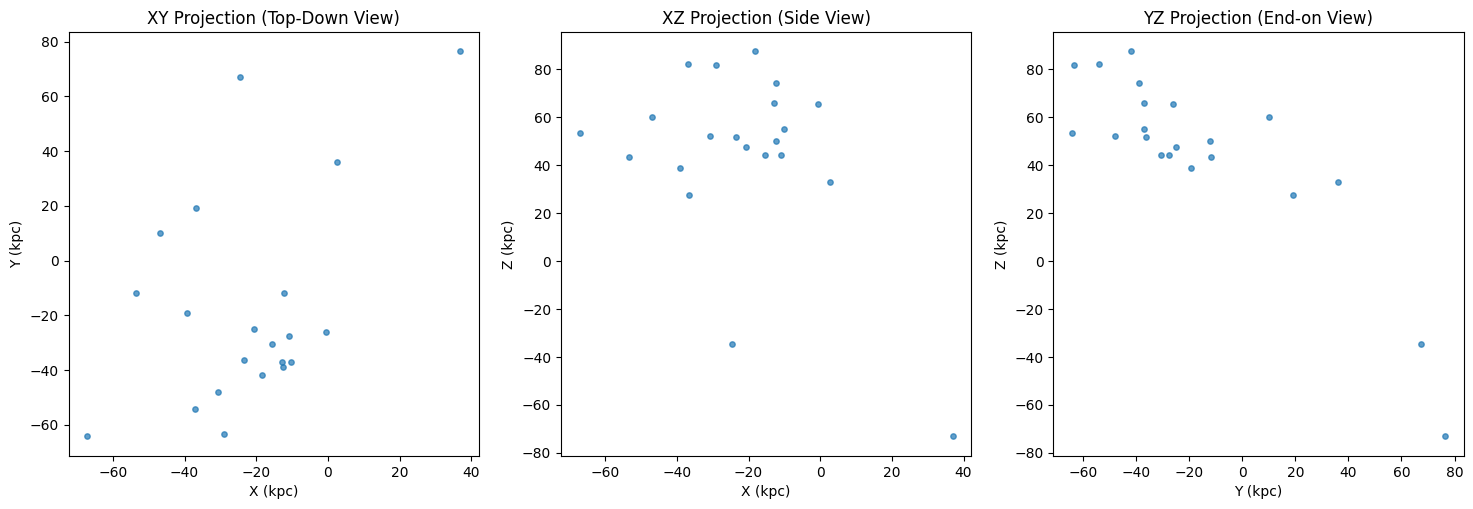

In [12]:
# xz, yz, xy plots of HVS in galactocentric frame
x = df['x']
y = df['y']
z = df['z']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5.5))
ax1.scatter(x, y, s=15, alpha=0.7)
ax1.set_title('XY Projection (Top-Down View)')
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')

ax2.scatter(x, z, s=15, alpha=0.7)
ax2.set_title('XZ Projection (Side View)')
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Z (kpc)')

ax3.scatter(y, z, s=15, alpha=0.7)
ax3.set_title('YZ Projection (End-on View)')
ax3.set_xlabel('Y (kpc)')
ax3.set_ylabel('Z (kpc)')

plt.show()

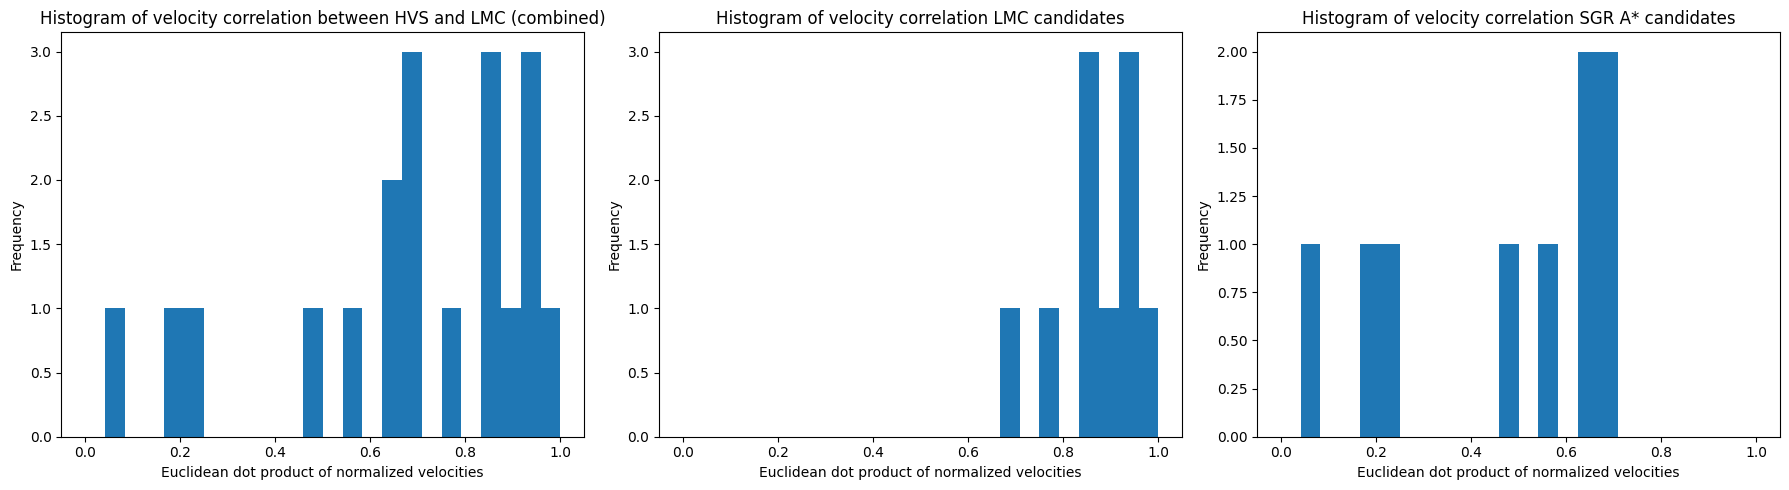

Higher correlation with LMC* vel: [6, 7, 9, 10, 13, 15, 16, 20, 22, 24]
Lower correlation with LMC* vel: [1, 4, 5, 8, 12, 14, 17, 18, 19, 21, 23]
12 incorrectly identified
13 incorrectly identified
Predictive accuracy: 0.9333333333333333 using a threshold of 0.7


In [19]:
# HVS velocity correlation with LMC velocity histogram
import seaborn as sb

# define galactocentric velocity of LMC from this paper https://arxiv.org/pdf/1301.0832 (Table 5)
lmc_v_x = -57
lmc_v_y = -226
lmc_v_z = 221
lmc_v_tot = 321

lmc_vel = np.array([lmc_v_x, lmc_v_y, lmc_v_z])
lmc_vel_unit = lmc_vel / np.linalg.norm(lmc_vel)

dots = []
bins = np.linspace(0,1,25)
threshold = 0.7
suspect_lmc = []
suspect_sgr = []

for index, data in df.iterrows():
    v_x = data['u']
    v_y = data['v']
    v_z = data['w']

    curr_v = np.array([v_x, v_y, v_z])
    curr_v_unit = curr_v / np.linalg.norm(curr_v)
    corr = np.dot(lmc_vel_unit, curr_v_unit)
    dots.append(corr)

    # higher correlation between HVS velocity and LMC velocity, suspect LMC origin
    if corr > threshold:
        suspect_lmc.append(int(data['HVS']))
    else:
        suspect_sgr.append(int(data['HVS']))

# lmc alignment into dataframe
df['lmc_alignment'] = dots
# for separate LMC, GC plots
lmc_mask = df['lmc_alignment'] > threshold
sgr_mask = df['lmc_alignment'] <= threshold
lmc_candidates = df[lmc_mask]
sgr_candidates = df[sgr_mask]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.hist(dots, bins=bins)
ax1.set_title('Histogram of velocity correlation between HVS and LMC (combined)')
ax1.set_xlabel('Euclidean dot product of normalized velocities')
ax1.set_ylabel('Frequency')

ax2.hist(lmc_candidates['lmc_alignment'].values, bins=bins)
ax2.set_title('Histogram of velocity correlation LMC candidates')
ax2.set_xlabel('Euclidean dot product of normalized velocities')
ax2.set_ylabel('Frequency')

ax3.hist(sgr_candidates['lmc_alignment'].values, bins=bins)
ax3.set_title('Histogram of velocity correlation SGR A* candidates')
ax3.set_xlabel('Euclidean dot product of normalized velocities')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Higher correlation with LMC* vel: " + str(suspect_lmc))
print("Lower correlation with LMC* vel: " + str(suspect_sgr))

# compare with actual predictions from Han. 0 represents higher likelihood assigned to SGR A* origin, 1 is higher likelihood assigned to LMC*
# paper: https://arxiv.org/pdf/2502.00102
truth_hvs = [1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
truth = [0, 0, None, 1, 1, None, 1, 1, 1, 0, None, 1, 1, None, 0, 0, 1, 0, 1, None, 1]

correct_ctr = 0
for i in range(len(truth_hvs)):
    hvs = truth_hvs[i]
    truth_val = truth[i]
    if truth_val != None:
        if truth_val == 1 and hvs in suspect_lmc:
            correct_ctr+=1
        elif truth_val == 0 and hvs in suspect_sgr:
            correct_ctr+=1
        else:
            print(str(hvs) + " incorrectly identified")

print("Predictive accuracy: " + str(correct_ctr/15) + " using a threshold of " + str(threshold)) # 15 comes from 20 HVS - 5 inconclusive ones (no LMC or SGR A* prediction)


In [ ]:
# point biserial correlation coefficient for asserting signficance of velocity correlation to truth
from scipy import stats

truth_data = {
    'HVS': truth_hvs,
    'truth': truth
}
truth_df = pd.DataFrame(truth_data)

if 'truth' not in df.columns:
    df['HVS'] = df['HVS'].astype(int)
    df = pd.merge(df, truth_df, on='HVS')
    df.dropna(subset=['truth'], inplace=True) #drop no predictions
    df['truth'] = df['truth'].astype(int)

# point biserial coefficient, used for one continous and one binary var
correlation, p_value = stats.pointbiserialr(df['lmc_alignment'], df['truth'])
print(f"\nPoint-Biserial Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


Point-Biserial Correlation Coefficient: 0.4773
P-value: 0.0615


In [ ]:
# 3d positional uncertainity plot for select HVS
#check

In [ ]:
# 3d velocity quiver/cone plot for select HVS

In [ ]:
# corner plot